In [12]:
import Pkg; Pkg.add("JuMP"); Pkg.add("GLPK"); Pkg.add("SCS"); Pkg.add("PicoSAT")
Pkg.add("LazySets");Pkg.add("Polyhedra"); Pkg.add("CDDLib"); Pkg.add("Parameters");
Pkg.add("Interpolations"); Pkg.add("Requires");

Pkg.add("TimerOutputs"); using TimerOutputs
Pkg.add("BenchmarkTools"); using BenchmarkTools

using LazySets
using Plots
using LinearAlgebra

include("NeuralVerification.jl/src/NeuralVerification.jl")


 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Res

Main.NeuralVerification

In [13]:
# assumes start_guess is contained in the output set 


# This will ignore the output_set sent in with the problem
#function RangeSearch(solver, start_guess, nnet, input_set, scaling_factor, desired_error=1e-10)
function RangeSearch(solver::NeuralVerification.Reluplex, problem::NeuralVerification.Problem, start_guess::Float64, max_error::Float64=0.1)
    ### Start by getting an upper bound
    step_num = 1
    strip_start = start_guess # consider other exploration strategies, maybe center + constant * 2^power
    strip_start_vals = [start_guess, strip_start]

    # Initial result
    strip_end = strip_start + 1e-5
    output_set = NeuralVerification.complement(NeuralVerification.Hyperrectangle(low=[strip_start], high=[strip_end]))
    problem = NeuralVerification.Problem(problem.network, problem.input, output_set)
    cur_result = NeuralVerification.solve(solver, problem)

    while cur_result.status == :violated
        println("Bounds (searching for upper): ", (strip_start, -1))
        # Setup your problem, and run the verifier
        strip_start = strip_start * 2.0
        strip_end = strip_start + 1e-5
        output_set = NeuralVerification.complement(NeuralVerification.Hyperrectangle(low=[strip_start], high=[strip_end]))
        problem = NeuralVerification.Problem(problem.network, problem.input, output_set)
        cur_result = NeuralVerification.solve(solver, problem)
        
        step_num = step_num + 1
        push!(strip_start_vals, strip_start)
    end
    
    lowest_hold = strip_start_vals[end]
    highest_violate = strip_start_vals[end-1]
    println("Bounds: ", (highest_violate, lowest_hold))

    ### Now, create a sequence that will converge to the maximum within the desired error by continually splitting your upper and lower bound
    while (lowest_hold - highest_violate > max_error)
        strip_start = (lowest_hold + highest_violate) / 2
        strip_end = strip_start + 1e-5
        println("Strip start, end: ", (strip_start, strip_end))
        output_set = NeuralVerification.complement(NeuralVerification.Hyperrectangle(low=[strip_start], high=[strip_end]))
        #output_set = LinearConstraint([1.0], strip_start)
        problem = NeuralVerification.Problem(nnet, input_set, output_set)
        cur_result = NeuralVerification.solve(solver, problem)
        if cur_result.status == :violated
            highest_violate = strip_start
        else
            lowest_hold = strip_start
        end
        println("Bounds: ", (highest_violate, lowest_hold))
    end
    return (highest_violate, lowest_hold) 
end

RangeSearch (generic function with 4 methods)

In [14]:
function create_random_network(layer_size_list)
    weight_matrix_list = []
    layers = []
    for i in 1:length(layer_size_list)-1
        weights = (rand( layer_size_list[i+1], layer_size_list[i]) .- 0.5) * 10
        bias = rand(layer_size_list[i+1])
        println("here")
        push!(layers, NeuralVerification.Layer(weights, bias, NeuralVerification.ReLU()))
        println("pushed")
    end
    return NeuralVerification.Network(layers)
end

create_random_network (generic function with 1 method)

[10.725820535605887]


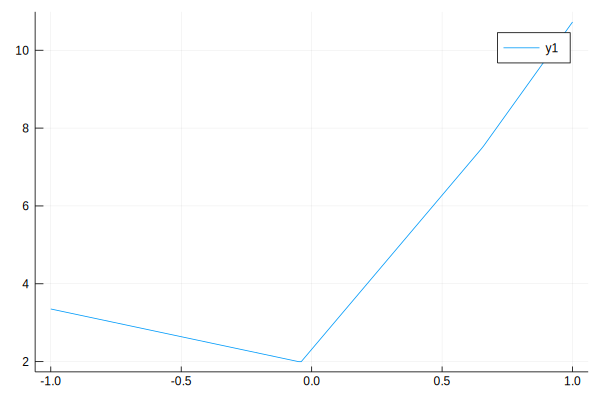

In [23]:
# Prototyping

#interior = HPolytope([LinearConstraint([1], -5)], LinearConstraint([-1], ))
interior = NeuralVerification.Hyperrectangle(low=[1.0], high=[1.2])
output_set = NeuralVerification.complement(interior)
problem = NeuralVerification.Problem(nnet, input_set, output_set)
#problem = NeuralVerification.Problem(nnet, input_set, -1)

println(NeuralVerification.compute_output(nnet, [1.0]))
outputs =[NeuralVerification.compute_output(nnet, [x])[1] for x=-1:0.01:1] 
plot(collect(-1:0.01:1), outputs)


In [31]:
# Instantiate a solver
solver_original = NeuralVerification.Reluplex()

# Define input and output sets
input_set = NeuralVerification.Hyperrectangle(low = [-1.0], high = [1.0])
#interior = NeuralVerification.Hyperrectangle(low=[0.4], high=[12.0])
interior = LinearConstraint([1.0], 7.45)

#output_set = NeuralVerification.complement(interior)

# Create the problem and solve it
problem = NeuralVerification.Problem(nnet, input_set, interior)
NeuralVerification.solve(solver_original, problem)

Main.NeuralVerification.CounterExampleResult(:violated, [0.6482766848510896])

In [21]:
### Define the problem

# Initialize the solvers
solver_original = NeuralVerification.Reluplex()
#solver = NeuralVerification.Reluplex_Optimization()

# Create your Neural Network
nnet = create_random_network([1, 2, 1])
#nnet = NeuralVerification.read_nnet("/Users/cstrong/Desktop/Stanford/Research/Reluplex/NNs/small_nnet.nnet")

# Restrict your input set
input_set = NeuralVerification.Hyperrectangle(low = [-1.0], high = [1.0])

# Find a start guess for the upper bound that you know is in the output set
center_output = NeuralVerification.compute_output(nnet, LazySets.center(input_set))[1]
problem = NeuralVerification.Problem(nnet, input_set, -2)
center_output

here
pushed
here
pushed


2.315483466674587

In [29]:
# Original Binary Search
result_original = RangeSearch(solver_original, problem, center_output, 1e-5)

Bounds (searching for upper): (2.315483466674587, -1)
Bounds (searching for upper): (4.630966933349174, -1)
Bounds: (4.630966933349174, 9.261933866698348)
Strip start, end: (6.94645040002376, 6.94646040002376)
Bounds: (6.94645040002376, 9.261933866698348)
Strip start, end: (8.104192133361053, 8.104202133361053)
Bounds: (6.94645040002376, 8.104192133361053)
Strip start, end: (7.525321266692407, 7.525331266692406)
Bounds: (6.94645040002376, 7.525321266692407)
Strip start, end: (7.2358858333580836, 7.235895833358083)
Bounds: (7.2358858333580836, 7.525321266692407)
Strip start, end: (7.380603550025246, 7.380613550025245)
Bounds: (7.380603550025246, 7.525321266692407)
Strip start, end: (7.452962408358826, 7.452972408358826)
Bounds: (7.452962408358826, 7.525321266692407)
Strip start, end: (7.489141837525617, 7.4891518375256165)
Bounds: (7.489141837525617, 7.525321266692407)
Strip start, end: (7.507231552109012, 7.5072415521090115)
Bounds: (7.507231552109012, 7.525321266692407)
Strip start, e

(7.511065017015845, 7.511073849884294)

In [19]:
# Warm Start Search
result_warmstart = NeuralVerification.reluplex_optimize(solver, problem, center_output, 1e-5)


UndefVarError: UndefVarError: reluplex_optimize not defined

In [20]:
result_original .- result_warmstart

UndefVarError: UndefVarError: result_original not defined